# Testing gym4ReaL within Dam environment

This notebook provides examples of usage and comparison of rule-based policies with a PPO agent

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%cd ../..

/media/samuele/Disco/PycharmProjectsUbuntu/gym4ReaL


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from tqdm import tqdm
from collections import OrderedDict

import gymnasium as gym
from gymnasium.wrappers import RescaleAction

from gym4real.envs.dam.utils import parameter_generator

In [3]:
sns.set_style('darkgrid')
plot_colors = sns.color_palette()
sns.set(font_scale=1.5)

alg_color = OrderedDict({
    'random': plot_colors[0],
    'fixed_action': plot_colors[1],
    'exp_avg_demand_action': plot_colors[2],
    'ppo': plot_colors[3]
})

alg_markers = OrderedDict({
    'random': '.',
    'fixed_action': 'o',
    'exp_avg_demand_action': 'v',
    # '50-50': 'P',
    'ppo': '*',
})

In [4]:
n_episodes = 1
rewards = {}

## Initialization of the environment

In [5]:
eval_params = parameter_generator(
    world_options='/media/samuele/Disco/PycharmProjectsUbuntu/gym4ReaL/gym4real/envs/dam/world_test.yaml',
    lake_params='/media/samuele/Disco/PycharmProjectsUbuntu/gym4ReaL/gym4real/envs/dam/lake.yaml'
)

eval_env = gym.make('gym4real/dam-v0', settings=eval_params)

print(type(eval_env))
# eval_env = RescaleAction(eval_env, min_action=-1., max_action=1.)

<class 'gymnasium.wrappers.common.OrderEnforcing'>


/media/samuele/Disco/PycharmProjectsUbuntu/gym4ReaL/.venv/lib/python3.12/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/media/samuele/Disco/PycharmProjectsUbuntu/gym4ReaL/.venv/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


### Deterministic policies

Here we will show three rule-based policies:
1. random action policy
2. fixed action policy
3. exponential average demand policy

### Random policy
The action is chosen randomly at each decision step.

In [6]:
alg = 'random'
rewards[alg] = []

for episode in tqdm(range(n_episodes)):
    obs, info = eval_env.reset(options={'rewind_profiles': episode == 0})
    done = False

    while not done:
        action = eval_env.action_space.sample()  # Randomly select an action
        obs, reward, terminated, truncated, info = eval_env.step(action)  # Return observation and reward
        done = terminated or truncated
        rewards[alg].append(reward)

100%|██████████| 1/1 [00:00<00:00, 33.08it/s]


### Fixed action policy
The action is fixed for each decision step.

In [7]:
alg = 'fixed_action'
rewards[alg] = []

fixed_action = 200.

for episode in tqdm(range(n_episodes)):
    obs, info = eval_env.reset(options={'rewind_profiles': episode == 0})
    done = False

    while not done:
        action = fixed_action
        obs, reward, terminated, truncated, info = eval_env.step(action)  # Return observation and reward
        done = terminated or truncated
        rewards[alg].append(reward)

100%|██████████| 1/1 [00:00<00:00, 63.63it/s]


### Exponential average demand policy
The action is the exponential average of the past demand in the observation vector

In [8]:
alg = 'exp_avg_demand_action'
rewards[alg] = []

index_exp_avg_demand = -1

for episode in tqdm(range(n_episodes)):
    obs, info = eval_env.reset(options={'rewind_profiles': episode == 0})
    done = False

    while not done:
        action = obs[index_exp_avg_demand]
        obs, reward, terminated, truncated, info = eval_env.step(action)  # Return observation and reward
        done = terminated or truncated
        rewards[alg].append(reward)

100%|██████████| 1/1 [00:00<00:00, 51.57it/s]


### PPO agent

In [9]:
import torch
import torch.nn as nn

# import the skrl components to build the RL system
from skrl.agents.torch.ppo import PPO, PPO_DEFAULT_CONFIG
from skrl.envs.wrappers.torch import wrap_env
from skrl.memories.torch import RandomMemory
from skrl.resources.preprocessors.torch import RunningStandardScaler
from skrl.resources.schedulers.torch import KLAdaptiveRL
from skrl.trainers.torch import SequentialTrainer
from skrl.utils import set_seed

from gym4real.algorithms.dam.ppo_skrl import Policy, Value

In [10]:
params = parameter_generator(
    world_options='/media/samuele/Disco/PycharmProjectsUbuntu/gym4ReaL/gym4real/envs/dam/world_train.yaml',
    lake_params='/media/samuele/Disco/PycharmProjectsUbuntu/gym4ReaL/gym4real/envs/dam/lake.yaml'
)

env = gym.make('gym4real/dam-v0', settings=params)
env = RescaleAction(env, min_action=-1., max_action=1.)
env = wrap_env(env)

/media/samuele/Disco/PycharmProjectsUbuntu/gym4ReaL/.venv/lib/python3.12/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/media/samuele/Disco/PycharmProjectsUbuntu/gym4ReaL/.venv/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(
[skrl:INFO] Environment wrapper: 'auto' (class: gymnasium.core.Env, gymnasium.utils.record_constructor.RecordConstructorArgs, gymnasium.wrappers.transform_action.TransformAction)
[skrl:INFO] Environment wrapper: gymnasium
[skrl:WARNING] Failed to check for a vectorized environment: module 'gymnasium.experimental' has no attribute 'vector'


In [11]:
set_seed(123)
device =  torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net_arch = (16, 16)

memory = RandomMemory(memory_size=2048, num_envs=env.num_envs, device=device)

models = {}
models["policy"] = Policy(env.observation_space, env.action_space, device=device, net_arch=net_arch, initial_log_std=-0.5)#, clip_actions=True)
models["value"] = Value(env.observation_space, env.action_space, device=device, net_arch=net_arch)

cfg = PPO_DEFAULT_CONFIG.copy()
cfg["rollouts"] = 2048
cfg["learning_epochs"] = 10
cfg["mini_batches"] = 32
cfg["discount_factor"] = 0.995
cfg["lambda"] = 0.95
cfg["learning_rate"] = 1e-5
cfg["learning_rate_scheduler"] = KLAdaptiveRL
cfg["learning_rate_scheduler_kwargs"] = {"kl_threshold": 0.008}
cfg["grad_norm_clip"] = 0.5
cfg["ratio_clip"] = 0.2
cfg["value_clip"] = 0.2
cfg["clip_predicted_values"] = False
cfg["entropy_loss_scale"] = 0.
cfg["value_loss_scale"] = 0.5
cfg["kl_threshold"] = 0
cfg["mixed_precision"] = True
cfg["state_preprocessor"] = RunningStandardScaler
cfg["state_preprocessor_kwargs"] = {"size": env.observation_space, "device": device}
cfg["value_preprocessor"] = RunningStandardScaler
cfg["value_preprocessor_kwargs"] = {"size": 1, "device": device}
# logging to TensorBoard and write checkpoints (in timesteps)
cfg["experiment"]["write_interval"] = 500
# cfg["experiment"]['experiment_name'] = args['exp_name']
cfg["experiment"]["checkpoint_interval"] = 500
cfg["experiment"]["directory"] = "runs/lake"

agent = PPO(models=models,
            memory=memory,
            cfg=cfg,
            observation_space=env.observation_space,
            action_space=env.action_space,
            device=device
            )

cfg_trainer = {"timesteps": 50000, "headless": True}
trainer = SequentialTrainer(cfg=cfg_trainer, env=env, agents=[agent])
agent.set_mode("eval")

[skrl:INFO] Seed: 123


In [12]:
trainer.train()

100%|██████████| 50000/50000 [01:29<00:00, 560.91it/s]


In [13]:
import os
import glob

# Get the latest log directory under 'runs/'
log_dirs = sorted(glob.glob(cfg["experiment"]["directory"] + "/*"), key=os.path.getmtime)
latest_log_dir = log_dirs[-1] if log_dirs else None
print(f"Latest log directory: {latest_log_dir}")

if latest_log_dir:
    %reload_ext tensorboard
    %tensorboard --logdir {latest_log_dir}

Latest log directory: runs/lake/25-05-09_14-15-02-835853_PPO


In [14]:
alg = 'ppo'
rewards[alg] = []

scaled_eval_env = RescaleAction(eval_env, min_action=-1., max_action=1.)
scaled_eval_env = wrap_env(scaled_eval_env)
scaled_eval_env.curr_year_data = None

with torch.no_grad():

    for episode in tqdm(range(n_episodes)):
        obs, info = scaled_eval_env.reset()
        done = False
        timesteps = 0
        while not done:
            output = agent.act(obs, timesteps, 365)
            action = output[-1]['mean_actions']
            obs, reward, terminated, truncated, info = scaled_eval_env.step(action)  # Return observation and reward
            done = terminated or truncated
            rewards[alg].append(reward.item())
            timesteps += 1

/media/samuele/Disco/PycharmProjectsUbuntu/gym4ReaL/.venv/lib/python3.12/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/media/samuele/Disco/PycharmProjectsUbuntu/gym4ReaL/.venv/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(
[skrl:INFO] Environment wrapper: 'auto' (class: gymnasium.core.Env, gymnasium.utils.record_constructor.RecordConstructorArgs, gymnasium.wrappers.transform_action.TransformAction)
[skrl:INFO] Environment wrapper: gymnasium
[skrl:WARNING] Failed to check for a vectorized environment: module 'gymnasium.experimental' has no attribute 'vector'
100%|██████████| 1/1 [00:00<00:00,  2.96it/s]


In [15]:
def plot_cum_rewards(res: dict, algs: list, sampling_rate=1):
    fig, ax = plt.subplots(1, 1, figsize=(12, 4), tight_layout=True)

    for i, alg in enumerate(algs):
        ax.plot(res[alg][::sampling_rate], label=alg, color=alg_color[alg], marker=alg_markers[alg], markevery=500)
        ax.legend()

In [16]:
algs_to_compare = ['random', 'fixed_action', 'exp_avg_demand_action', 'ppo']

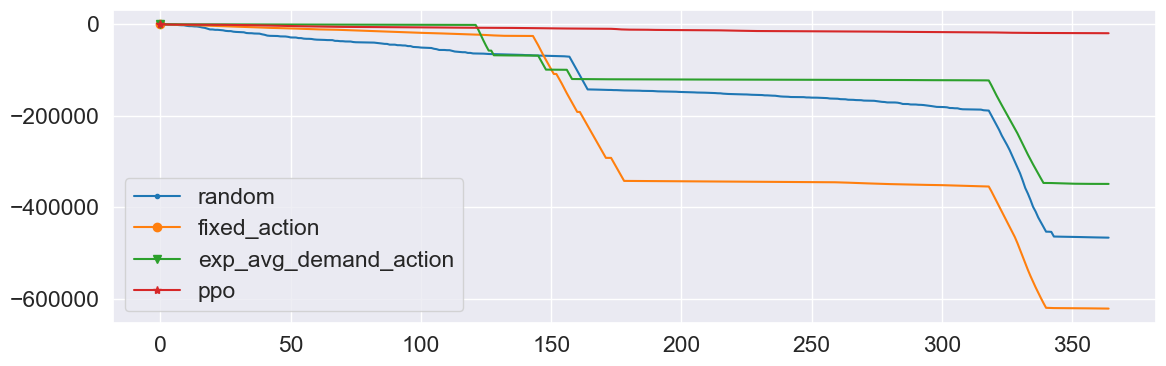

In [17]:
rewards = {key: np.array(val) for key, val in rewards.items()}
cum_rewards = {key: np.cumsum(val) for key, val in rewards.items()}

plot_cum_rewards(res=cum_rewards, algs=algs_to_compare)